In [1]:
!which python; python --version; pwd

/mnt/qb/work/macke/mwe102/.conda/sbi/bin/python
Python 3.10.15
/mnt/qb/work/macke/mwe102/sourcerer-sequential/notebooks


In [120]:
import os
from time import time_ns; from datetime import datetime
import numpy as np; import matplotlib.pyplot as plt
import torch
from corner import corner
from omegaconf import OmegaConf as OC

In [121]:
run_id = datetime.now().strftime("%Y%m%d_%H%M%S")
print(f'run id: {run_id}')

run id: 20241116_171907


In [122]:
torch.cuda.empty_cache()
!nvidia-smi

Sat Nov 16 17:19:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     On  | 00000000:DB:00.0 Off |                  N/A |
|  0%   52C    P2             134W / 250W |   4733MiB / 11264MiB |     43%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [123]:
from sourcerer.fit_surrogate import (
    create_train_val_dataloaders,
    fit_conditional_normalizing_flow,
)

from sourcerer.likelihood_estimator import train_lml_source
from sourcerer.real_nvp import (
    Sampler,
    RealNVPs,
    TemperedUniform, # a little slanted uniform to make log-density well defined
    kozachenko_leonenko_estimator,
)

from sourcerer.sbi_classifier_two_sample_test import c2st_scores
from sourcerer.simulators import (
    InverseKinematicsSimulator,
    LotkaVolterraSimulator,
    SIRSimulator,
    SLCPSimulator,
    TwoMoonsSimulator,
)
from sourcerer.sliced_wasserstein import sliced_wasserstein_distance
from sourcerer.utils import (
    save_cfg_as_yaml,
    save_fig,
    save_numpy_csv,
    save_state_dict,
    script_or_command_line_cfg,
    set_seed,
)
from sourcerer.wasserstein_estimator import train_source

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device}")

using cuda


In [124]:
def get_simulator(cfg):
    if cfg.simulator.self == "two_moons":
        return TwoMoonsSimulator()
    elif cfg.simulator.self == "inverse_kinematics":
        return InverseKinematicsSimulator()
    elif cfg.simulator.self == "slcp":
        return SLCPSimulator()
    elif cfg.simulator.self == "sir":
        return SIRSimulator()
    elif cfg.simulator.self == "lotka_volterra":
        return LotkaVolterraSimulator()

In [125]:
# simulator_str = "inverse_kinematics"
simulator_str = "slcp"
# simulator_str = "two_moons"

In [126]:
# Define config
# NOTE: These overrides only take effect if this script is run interactively
local_overrides = [
    f"base.tag=debug_{run_id}",
    f"base.folder=sequential_slcp_oneshot",# _{run_id}", # this creates a new folder specific to this run --> need to be unique when I run as script
    f"simulator={simulator_str}",
    "surrogate.self=train_surrogate",
    "+surrogate.num_training_samples=15000",

"surrogate.flow_length=8",
"surrogate.hidden_layer_dim=50",

"+surrogate.nb_epochs=5000",
"+surrogate.surrogate_lr=0.0001",
"+surrogate.surrogate_weight_decay=0.00005",

"+surrogate.early_stopping_patience=50"
]

cfg = script_or_command_line_cfg(
    config_name="config",
    config_path="../conf",
    local_overrides=local_overrides,
    name=__name__,
)

assert cfg.base.tag is not None
assert cfg.base.folder is not None

print(OC.to_yaml(cfg))

base:
  tag: debug_20241116_171907
  folder: sequential_slcp_oneshot
  base_path: ../results_sourcerer
  seed: null
simulator:
  self: slcp
  box_domain_lower: -5.0
  box_domain_upper: 5.0
surrogate:
  self: train_surrogate
  flow_length: 8
  hidden_layer_dim: 50
  num_training_samples: 15000
  nb_epochs: 5000
  surrogate_lr: 0.0001
  surrogate_weight_decay: 5.0e-05
  early_stopping_patience: 50
source_model:
  self: sampler
  num_hidden_layers: 3
  hidden_layer_dim: 100
source:
  self: wasserstein
  num_obs: 10000
  num_eval_obs: 10000
  wasserstein_slices: 500
  wasserstein_order: 2
  use_log_sw: true
  num_chunks: 1
  num_kole_samples: 512
  pretraining_steps: 0
  linear_decay_steps: 500
  lambda_steps: 3000
  fin_lambda: 0.35
  learning_rate: 0.0001
  weight_decay: 1.0e-05
  early_stopping_patience: 500



In [127]:
# save the above config file in ../results_sourcerer/sequential directory
save_cfg_as_yaml(
    cfg,
    f"{cfg.base.tag}_cfg.yaml",
    folder=cfg.base.folder,
    base_path=cfg.base.base_path,
)

# set seed
if cfg.base.seed is None:
    random_random_seed = 20367 #np.random.randint(2**16)
    set_seed(random_random_seed)
    save_numpy_csv(
        np.array([random_random_seed], dtype=int),
        file_name=f"{cfg.base.tag}_seed.csv",
        folder=cfg.base.folder,
        base_path=cfg.base.base_path,
    )
    print(f"seed: {random_random_seed}")
else:
    set_seed(cfg.base.seed)

seed: 20367


In [128]:
# Define Simulator and reference domain. Train a surrogate/load an existing surrogate if necessary.
simulator = get_simulator(cfg)
simulator = simulator.to(device)

## this is the initial distribution to sample theta from to train the surrogate
box_domain = TemperedUniform(
    cfg.simulator.box_domain_lower,
    cfg.simulator.box_domain_upper,
    simulator.xdim,
    device=device,
)

# notation here: θ (which is x here), and x (which is x here) 
print(f"θ/parameter dimension: {simulator.xdim}")
print(f"x/observation dimension: {simulator.ydim}")

θ/parameter dimension: 5
x/observation dimension: 8


In [129]:
surrogate = RealNVPs(
    flow_length=cfg.surrogate.flow_length, # 1 RealNVP layer
    data_dim=simulator.ydim,    # this is x ~ p(x|theta)
    context_dim=simulator.xdim, # this is theta! okay so context dim is theta's dimension
    hidden_layer_dim=cfg.surrogate.hidden_layer_dim # 5,
)
surrogate = surrogate.to(device)

surro_optimizer = torch.optim.Adam(
    surrogate.parameters(),
    lr=cfg.surrogate.surrogate_lr, # 0.0001
    weight_decay=cfg.surrogate.surrogate_weight_decay, # 0.00005
)

assert cfg.surrogate.self == "train_surrogate"

In [130]:
cfg.source.fin_lambda

0.35

In [131]:
# add this to the config later, create a folder called `sequential`
TOTAL_SIMULATION_BUDGET = 20_000 #cfg.surrogate.num_training_samples # 15000 -> variable
NUMBER_OF_ITERATIONS = 1
MINIMUM_SAMPLES_PER_ITERATION = TOTAL_SIMULATION_BUDGET // NUMBER_OF_ITERATIONS
# NUMBER_OF_ITERATIONS = TOTAL_SIMULATION_BUDGET // MINIMUM_SAMPLES_PER_ITERATION
print(f"{NUMBER_OF_ITERATIONS=}")
print(f"{MINIMUM_SAMPLES_PER_ITERATION=}")

# high simulation budget vs. low simulation budget (2000)
# low simulation budget -- iterative method

NUMBER_OF_ITERATIONS=1
MINIMUM_SAMPLES_PER_ITERATION=20000


In [132]:
BUDGET_SCHEDULER = np.ones(NUMBER_OF_ITERATIONS) / NUMBER_OF_ITERATIONS
# BUDGET_SCHEDULER = np.array([0.4, 0.2, 0.15, 0.15, 0.1])
BUDGET_PER_ITERATION = (BUDGET_SCHEDULER*TOTAL_SIMULATION_BUDGET).astype(int)
BUDGET_PER_ITERATION

array([20000])

In [133]:
## used for evaluation of surrogate and estimated source later
gt_source = simulator.sample_prior(cfg.source.num_obs)          # 10k thetas from true source distribution
gt_source_two = simulator.sample_prior(cfg.source.num_eval_obs) # 10k thetas for validation

with torch.no_grad():
    # simulator generated observations/pfs from the above 2 sets of 10k thetas
    gt_simulator = simulator.sample(context=gt_source)
    gt_simulator_two = simulator.sample(context=gt_source_two)

print("Sliced wassertein distance on groundtruth y:")
excepted_distance = sliced_wasserstein_distance(
    gt_simulator[: cfg.source.num_eval_obs],  # from theta1
    gt_simulator_two,                         # from theta2 (both ground truth)
    num_projections=4096,
    device=device,
).item()
print(f"expected/baseline swd: {excepted_distance}, log of that: {np.log(excepted_distance)}")

Sliced wassertein distance on groundtruth y:
expected/baseline swd: 0.17703132331371307, log of that: -1.7314285941911898


In [134]:
## define source model
if cfg.source_model.self == "sampler":
    # easier to scale, used in the paper
    # note that Sampler() model does not have log-density evaluation
    print("init sampler source")
    source = Sampler(
        xdim=simulator.xdim,
        input_noise_dim=simulator.xdim,
        hidden_layer_dim=cfg.source_model.hidden_layer_dim,
        num_hidden_layers=cfg.source_model.num_hidden_layers,
        low=cfg.simulator.box_domain_lower,
        high=cfg.simulator.box_domain_upper,
    )
elif cfg.source_model.self == "real_nvp":
    source = RealNVPs(
        data_dim=simulator.xdim,
        context_dim=0,  # here we are not using it as a conditioning mechanism!
        hidden_layer_dim=cfg.source_model.hidden_layer_dim,
        flow_length=cfg.source_model.flow_length,
        low=cfg.simulator.box_domain_lower,
        high=cfg.simulator.box_domain_upper,
    )
else:
    raise ValueError

source = source.to(device)

# Train source model
optimizer = torch.optim.Adam(
    source.parameters(),
    lr=cfg.source.learning_rate,
    weight_decay=cfg.source.weight_decay,
)

# This is the scheduled values of lambda - first we linearly decay from lambda=1.0 (only entropy) until a minimum value of lambda. Then we stay at that value of lambda for more iterations.
schedule = torch.cat(
    [
        torch.ones(cfg.source.pretraining_steps),
        torch.linspace(
            1.0,
            cfg.source.fin_lambda,
            cfg.source.linear_decay_steps,
        ),
        cfg.source.fin_lambda * torch.ones(cfg.source.lambda_steps),
    ]
)

schedule

init sampler source


tensor([1.0000, 0.9987, 0.9974,  ..., 0.3500, 0.3500, 0.3500])

In [135]:
cfg.source.pretraining_steps

0

ITERATION: 1/1 training with 20000 samples
Epoch: 0, Train Loss: 6416.475281730531, Val Loss: 1341.612564086914
Epoch: 500, Train Loss: 18.863523301624117, Val Loss: 20.53451383113861
Validation loss did not improve for 50 epochs, stopping training after 549 epochs.


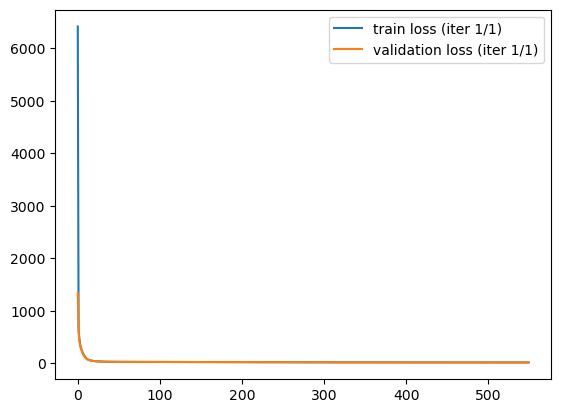

Surrogate vs Simulator y-space C2ST AUC after iteration 0: 0.5254
Surrogate vs Simulator y-space SWD AUC after iteration 0: 0.4240751564502716
Epoch x Chunk: 0, Weighted Loss: 6.269183355996869, Entropy loss: 6.269183355996869, Wasser loss: 0.9353914856910706
Epoch x Chunk: 500, Weighted Loss: -0.2786900740663705, Entropy loss: 1.6425944387217841, Wasser loss: -1.313227891921997
Epoch x Chunk: 1000, Weighted Loss: -0.37854491101490995, Entropy loss: 1.5765601260079807, Wasser loss: -1.4312938451766968
Epoch x Chunk: 1500, Weighted Loss: -0.4240392098817326, Entropy loss: 1.6410423598032464, Wasser loss: -1.536006212234497
Epoch x Chunk: 2000, Weighted Loss: -0.46958736634355513, Entropy loss: 1.5660911765425825, Wasser loss: -1.5657219886779785
Training loss did not improve. Stopped training after 2100 epochs x chunks.
y c2st AUC on simulator: 0.5425500000000001
y c2st AUC on surrogate: 0.54295
Source c2st AUC: 0.7603000000000002
Ground truth source entropy estimate: 9.165601713214292


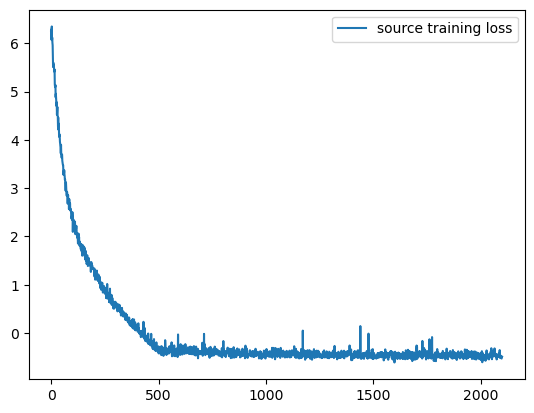

In [136]:
surro_train_domain_distribution = box_domain  # initialization
train_losses = []
val_losses = []
train_source_losses = []

iteration = 0
# start loop here, don't initialize surrogate again!
for _ in range(NUMBER_OF_ITERATIONS):
    print(f"ITERATION: {iteration+1}/{NUMBER_OF_ITERATIONS} training with {BUDGET_PER_ITERATION[_]} samples")
    surro_train_domain = surro_train_domain_distribution.sample(BUDGET_PER_ITERATION[_]).detach()#?
    surro_train_push_forward = simulator.sample(surro_train_domain) # real simulator, budget
    

    train_dataset, val_dataset = create_train_val_dataloaders(
        surro_train_push_forward, # observations: x
        surro_train_domain,       #   parameters: θ
    )

    train_loss, val_loss = fit_conditional_normalizing_flow(
        network=surrogate,
        optimizer=surro_optimizer,
        training_dataset=train_dataset,
        validation_dataset=val_dataset,
        nb_epochs=cfg.surrogate.nb_epochs,#//NUMBER_OF_ITERATIONS, ## shall we cut down on epochs?
        early_stopping_patience=cfg.surrogate.early_stopping_patience,
        print_every=500,
    )

    train_losses.extend(train_loss); val_losses.extend(val_loss) # concatenate losses across iterations
    
    if iteration == NUMBER_OF_ITERATIONS-1:
        # only save the final surrogate
        torch.save(
            surrogate.state_dict(),
            os.path.join(
                cfg.base.base_path, cfg.base.folder, f"{cfg.base.tag}_surrogate_{iteration}.pt"
            ),
        )
    
    plt.plot(train_loss, label=f"train loss (iter {iteration+1}/{NUMBER_OF_ITERATIONS})")
    plt.plot(val_loss, label=f"validation loss (iter {iteration+1}/{NUMBER_OF_ITERATIONS})")
    plt.legend()
    plt.show()
    
    # evaluate the current surrogate
    surrogate.eval()
    with torch.no_grad():
        # surrogate generated observations from the above 2 sets of 10k thetas
        gt_surrogate = surrogate.sample(size=cfg.source.num_obs, context=gt_source)
        gt_surrogate_two = surrogate.sample(size=cfg.source.num_eval_obs, context=gt_source_two)
    
    current_c2st = np.mean(c2st_scores(gt_simulator.cpu(), gt_surrogate.cpu()))
    current_swd = sliced_wasserstein_distance(gt_simulator, gt_surrogate,
                                              num_projections=4096, device=device
                                             ).item()
    
    print(f"Surrogate vs Simulator y-space C2ST AUC after iteration {iteration}: {current_c2st}")
    print(f"Surrogate vs Simulator y-space SWD AUC after iteration {iteration}: {current_swd}")
    
    
    # now fit a source with this new surrogate
    train_source_loss = train_source(
        data=gt_simulator, # observations sampled using simulator.sample(context=gt_source)
        source_model=source,
        simulator=surrogate,  ##### ALWAYS PASSING SURROGATE HERE!!!
        optimizer=optimizer,
        entro_dist=None,  # default uniform is used
        kld_samples=cfg.source.num_kole_samples, # 512
        entro_lambda=schedule,
        wasser_p=cfg.source.wasserstein_order,   # 2
        wasser_np=cfg.source.wasserstein_slices, # 500
        use_log_sw=cfg.source.use_log_sw,   # True => log_or_id = torch.log
        num_chunks=cfg.source.num_chunks,   # 1
        epochs=cfg.source.pretraining_steps # 0
        + cfg.source.linear_decay_steps     # 500
        + cfg.source.lambda_steps,          # 3000
        min_epochs_x_chus=cfg.source.pretraining_steps + cfg.source.linear_decay_steps,
        early_stopping_patience=cfg.source.early_stopping_patience, # 500
        device=device,
        print_every=500,
    )
    train_source_losses.extend(train_source_loss)
    
    # Evaluate trained source model
    source.eval()
    surrogate.eval()
    with torch.no_grad():
        # sample some θ-s from the estimated source
        estimated_source = source.sample(cfg.source.num_eval_obs)
        # sample some x-s from those θ-s from the surrogate (pushforward using surrogate)
        surro_estimated_pf = surrogate.sample(cfg.source.num_eval_obs, estimated_source)
        # sample some x-s from those θ-s from the actual simulator (pushforward using true simulator)
        simu_estimated_pf = simulator.sample(estimated_source)
    
    
    # Classifier two sample tests
    simu_c2st = np.mean(c2st_scores(simu_estimated_pf.cpu(), gt_simulator_two.cpu()))
    print(f"y c2st AUC on simulator: {simu_c2st}")
    
    surro_c2st = np.mean(c2st_scores(surro_estimated_pf.cpu(), gt_surrogate_two.cpu()))
    print(f"y c2st AUC on surrogate: {surro_c2st}")
    
    source_c2st = np.mean(
        c2st_scores( # 2 `sets` of samples of thetas, from the estimated and the ground truth sources
            estimated_source.cpu(),
            gt_source_two.cpu(),
        )
    )
    print(f"Source c2st AUC: {source_c2st}")

    # print("Estimate source entropies")
    gt_source_kole = kozachenko_leonenko_estimator(gt_source_two, on_torus=False).item()
    estimated_source_kole = kozachenko_leonenko_estimator(
        estimated_source, on_torus=False
    ).item()
    
    print(f"Ground truth source entropy estimate: {gt_source_kole}")
    print(f"Estimated source entropy estimate: {estimated_source_kole}")


    ## update the source for next iteration of updating the surrogate
    iteration += 1
    surro_train_domain_distribution = source
    print("--__--"*10)

plt.plot(train_source_losses, label=f"source training loss")
plt.legend()
plt.show()

# 15000 oneshot

ITERATION: 1/1 training with 15000 samples
Epoch: 0, Train Loss: 13676.999236411237, Val Loss: 1698.7649180094402
Epoch: 500, Train Loss: 20.147718510729202, Val Loss: 21.256404558817547
Validation loss did not improve for 50 epochs, stopping training after 610 epochs.


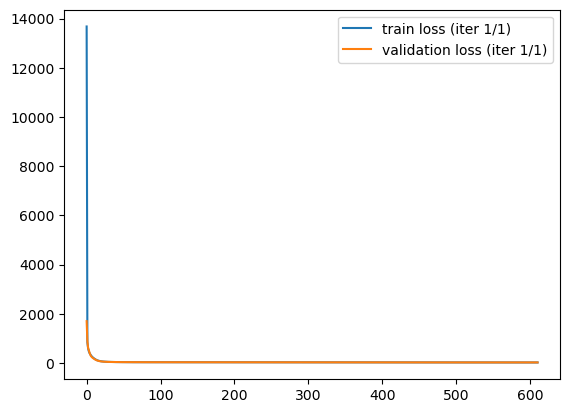

Surrogate vs Simulator y-space C2ST AUC after iteration 0: 0.55205
Surrogate vs Simulator y-space SWD AUC after iteration 0: 0.4592050313949585
Epoch x Chunk: 0, Weighted Loss: 6.269183355996869, Entropy loss: 6.269183355996869, Wasser loss: 0.920069694519043
Epoch x Chunk: 500, Weighted Loss: -0.3318658371858433, Entropy loss: 1.5601853511215635, Wasser loss: -1.3506627082824707
Epoch x Chunk: 1000, Weighted Loss: -0.35852632150891595, Entropy loss: 1.5861359018893006, Wasser loss: -1.4056521654129028
Epoch x Chunk: 1500, Weighted Loss: -0.3785411008355912, Entropy loss: 1.586795763472673, Wasser loss: -1.43679940700531
Epoch x Chunk: 2000, Weighted Loss: -0.42612522394685737, Entropy loss: 1.5337677049929708, Wasser loss: -1.481452226638794
Training loss did not improve. Stopped training after 2158 epochs x chunks.
y c2st AUC on simulator: 0.5367
y c2st AUC on surrogate: 0.5493
Source c2st AUC: 0.76105
Ground truth source entropy estimate: 9.165601713214292
Estimated source entropy e

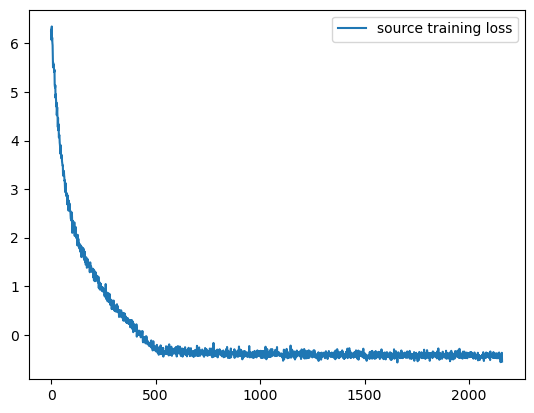

In [119]:
surro_train_domain_distribution = box_domain  # initialization
train_losses = []
val_losses = []
train_source_losses = []

iteration = 0
# start loop here, don't initialize surrogate again!
for _ in range(NUMBER_OF_ITERATIONS):
    print(f"ITERATION: {iteration+1}/{NUMBER_OF_ITERATIONS} training with {BUDGET_PER_ITERATION[_]} samples")
    surro_train_domain = surro_train_domain_distribution.sample(BUDGET_PER_ITERATION[_]).detach()#?
    surro_train_push_forward = simulator.sample(surro_train_domain) # real simulator, budget
    

    train_dataset, val_dataset = create_train_val_dataloaders(
        surro_train_push_forward, # observations: x
        surro_train_domain,       #   parameters: θ
    )

    train_loss, val_loss = fit_conditional_normalizing_flow(
        network=surrogate,
        optimizer=surro_optimizer,
        training_dataset=train_dataset,
        validation_dataset=val_dataset,
        nb_epochs=cfg.surrogate.nb_epochs,#//NUMBER_OF_ITERATIONS, ## shall we cut down on epochs?
        early_stopping_patience=cfg.surrogate.early_stopping_patience,
        print_every=500,
    )

    train_losses.extend(train_loss); val_losses.extend(val_loss) # concatenate losses across iterations
    
    if iteration == NUMBER_OF_ITERATIONS-1:
        # only save the final surrogate
        torch.save(
            surrogate.state_dict(),
            os.path.join(
                cfg.base.base_path, cfg.base.folder, f"{cfg.base.tag}_surrogate_{iteration}.pt"
            ),
        )
    
    plt.plot(train_loss, label=f"train loss (iter {iteration+1}/{NUMBER_OF_ITERATIONS})")
    plt.plot(val_loss, label=f"validation loss (iter {iteration+1}/{NUMBER_OF_ITERATIONS})")
    plt.legend()
    plt.show()
    
    # evaluate the current surrogate
    surrogate.eval()
    with torch.no_grad():
        # surrogate generated observations from the above 2 sets of 10k thetas
        gt_surrogate = surrogate.sample(size=cfg.source.num_obs, context=gt_source)
        gt_surrogate_two = surrogate.sample(size=cfg.source.num_eval_obs, context=gt_source_two)
    
    current_c2st = np.mean(c2st_scores(gt_simulator.cpu(), gt_surrogate.cpu()))
    current_swd = sliced_wasserstein_distance(gt_simulator, gt_surrogate,
                                              num_projections=4096, device=device
                                             ).item()
    
    print(f"Surrogate vs Simulator y-space C2ST AUC after iteration {iteration}: {current_c2st}")
    print(f"Surrogate vs Simulator y-space SWD AUC after iteration {iteration}: {current_swd}")
    
    
    # now fit a source with this new surrogate
    train_source_loss = train_source(
        data=gt_simulator, # observations sampled using simulator.sample(context=gt_source)
        source_model=source,
        simulator=surrogate,  ##### ALWAYS PASSING SURROGATE HERE!!!
        optimizer=optimizer,
        entro_dist=None,  # default uniform is used
        kld_samples=cfg.source.num_kole_samples, # 512
        entro_lambda=schedule,
        wasser_p=cfg.source.wasserstein_order,   # 2
        wasser_np=cfg.source.wasserstein_slices, # 500
        use_log_sw=cfg.source.use_log_sw,   # True => log_or_id = torch.log
        num_chunks=cfg.source.num_chunks,   # 1
        epochs=cfg.source.pretraining_steps # 0
        + cfg.source.linear_decay_steps     # 500
        + cfg.source.lambda_steps,          # 3000
        min_epochs_x_chus=cfg.source.pretraining_steps + cfg.source.linear_decay_steps,
        early_stopping_patience=cfg.source.early_stopping_patience, # 500
        device=device,
        print_every=500,
    )
    train_source_losses.extend(train_source_loss)
    
    # Evaluate trained source model
    source.eval()
    surrogate.eval()
    with torch.no_grad():
        # sample some θ-s from the estimated source
        estimated_source = source.sample(cfg.source.num_eval_obs)
        # sample some x-s from those θ-s from the surrogate (pushforward using surrogate)
        surro_estimated_pf = surrogate.sample(cfg.source.num_eval_obs, estimated_source)
        # sample some x-s from those θ-s from the actual simulator (pushforward using true simulator)
        simu_estimated_pf = simulator.sample(estimated_source)
    
    
    # Classifier two sample tests
    simu_c2st = np.mean(c2st_scores(simu_estimated_pf.cpu(), gt_simulator_two.cpu()))
    print(f"y c2st AUC on simulator: {simu_c2st}")
    
    surro_c2st = np.mean(c2st_scores(surro_estimated_pf.cpu(), gt_surrogate_two.cpu()))
    print(f"y c2st AUC on surrogate: {surro_c2st}")
    
    source_c2st = np.mean(
        c2st_scores( # 2 `sets` of samples of thetas, from the estimated and the ground truth sources
            estimated_source.cpu(),
            gt_source_two.cpu(),
        )
    )
    print(f"Source c2st AUC: {source_c2st}")

    # print("Estimate source entropies")
    gt_source_kole = kozachenko_leonenko_estimator(gt_source_two, on_torus=False).item()
    estimated_source_kole = kozachenko_leonenko_estimator(
        estimated_source, on_torus=False
    ).item()
    
    print(f"Ground truth source entropy estimate: {gt_source_kole}")
    print(f"Estimated source entropy estimate: {estimated_source_kole}")


    ## update the source for next iteration of updating the surrogate
    iteration += 1
    surro_train_domain_distribution = source
    print("--__--"*10)

plt.plot(train_source_losses, label=f"source training loss")
plt.legend()
plt.show()

# 12000 one shot

ITERATION: 1/1 training with 12000 samples
Epoch: 0, Train Loss: 5555.741301687141, Val Loss: 677.6630554199219
Epoch: 500, Train Loss: 20.849692344665527, Val Loss: 21.982402038574218
Validation loss did not improve for 50 epochs, stopping training after 637 epochs.


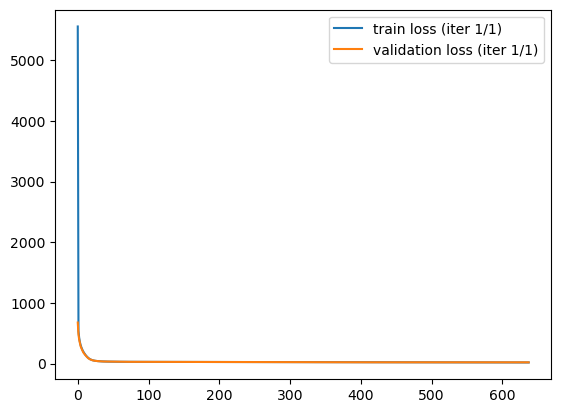

Surrogate vs Simulator y-space C2ST AUC after iteration 0: 0.5708
Surrogate vs Simulator y-space SWD AUC after iteration 0: 0.5603686571121216
Epoch x Chunk: 0, Weighted Loss: 6.269183355996869, Entropy loss: 6.269183355996869, Wasser loss: 0.89986252784729
Epoch x Chunk: 500, Weighted Loss: -0.15309710939650323, Entropy loss: 1.568981389246221, Wasser loss: -1.0803701877593994
Epoch x Chunk: 1000, Weighted Loss: -0.2852397236749399, Entropy loss: 1.633627024290889, Wasser loss: -1.3184757232666016
Epoch x Chunk: 1500, Weighted Loss: -0.31791622746475967, Entropy loss: 1.6755093760949427, Wasser loss: -1.3912992477416992
Training loss did not improve. Stopped training after 1508 epochs x chunks.
y c2st AUC on simulator: 0.5447000000000001
y c2st AUC on surrogate: 0.5426
Source c2st AUC: 0.7617
Ground truth source entropy estimate: 9.165601713214292
Estimated source entropy estimate: 9.695296140731923
--__----__----__----__----__----__----__----__----__----__--


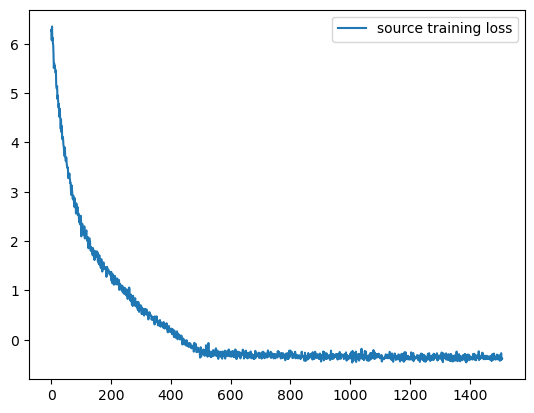

In [102]:
surro_train_domain_distribution = box_domain  # initialization
train_losses = []
val_losses = []
train_source_losses = []

iteration = 0
# start loop here, don't initialize surrogate again!
for _ in range(NUMBER_OF_ITERATIONS):
    print(f"ITERATION: {iteration+1}/{NUMBER_OF_ITERATIONS} training with {BUDGET_PER_ITERATION[_]} samples")
    surro_train_domain = surro_train_domain_distribution.sample(BUDGET_PER_ITERATION[_]).detach()#?
    surro_train_push_forward = simulator.sample(surro_train_domain) # real simulator, budget
    

    train_dataset, val_dataset = create_train_val_dataloaders(
        surro_train_push_forward, # observations: x
        surro_train_domain,       #   parameters: θ
    )

    train_loss, val_loss = fit_conditional_normalizing_flow(
        network=surrogate,
        optimizer=surro_optimizer,
        training_dataset=train_dataset,
        validation_dataset=val_dataset,
        nb_epochs=cfg.surrogate.nb_epochs,#//NUMBER_OF_ITERATIONS, ## shall we cut down on epochs?
        early_stopping_patience=cfg.surrogate.early_stopping_patience,
        print_every=500,
    )

    train_losses.extend(train_loss); val_losses.extend(val_loss) # concatenate losses across iterations
    
    if iteration == NUMBER_OF_ITERATIONS-1:
        # only save the final surrogate
        torch.save(
            surrogate.state_dict(),
            os.path.join(
                cfg.base.base_path, cfg.base.folder, f"{cfg.base.tag}_surrogate_{iteration}.pt"
            ),
        )
    
    plt.plot(train_loss, label=f"train loss (iter {iteration+1}/{NUMBER_OF_ITERATIONS})")
    plt.plot(val_loss, label=f"validation loss (iter {iteration+1}/{NUMBER_OF_ITERATIONS})")
    plt.legend()
    plt.show()
    
    # evaluate the current surrogate
    surrogate.eval()
    with torch.no_grad():
        # surrogate generated observations from the above 2 sets of 10k thetas
        gt_surrogate = surrogate.sample(size=cfg.source.num_obs, context=gt_source)
        gt_surrogate_two = surrogate.sample(size=cfg.source.num_eval_obs, context=gt_source_two)
    
    current_c2st = np.mean(c2st_scores(gt_simulator.cpu(), gt_surrogate.cpu()))
    current_swd = sliced_wasserstein_distance(gt_simulator, gt_surrogate,
                                              num_projections=4096, device=device
                                             ).item()
    
    print(f"Surrogate vs Simulator y-space C2ST AUC after iteration {iteration}: {current_c2st}")
    print(f"Surrogate vs Simulator y-space SWD AUC after iteration {iteration}: {current_swd}")
    
    
    # now fit a source with this new surrogate
    train_source_loss = train_source(
        data=gt_simulator, # observations sampled using simulator.sample(context=gt_source)
        source_model=source,
        simulator=surrogate,  ##### ALWAYS PASSING SURROGATE HERE!!!
        optimizer=optimizer,
        entro_dist=None,  # default uniform is used
        kld_samples=cfg.source.num_kole_samples, # 512
        entro_lambda=schedule,
        wasser_p=cfg.source.wasserstein_order,   # 2
        wasser_np=cfg.source.wasserstein_slices, # 500
        use_log_sw=cfg.source.use_log_sw,   # True => log_or_id = torch.log
        num_chunks=cfg.source.num_chunks,   # 1
        epochs=cfg.source.pretraining_steps # 0
        + cfg.source.linear_decay_steps     # 500
        + cfg.source.lambda_steps,          # 3000
        min_epochs_x_chus=cfg.source.pretraining_steps + cfg.source.linear_decay_steps,
        early_stopping_patience=cfg.source.early_stopping_patience, # 500
        device=device,
        print_every=500,
    )
    train_source_losses.extend(train_source_loss)
    
    # Evaluate trained source model
    source.eval()
    surrogate.eval()
    with torch.no_grad():
        # sample some θ-s from the estimated source
        estimated_source = source.sample(cfg.source.num_eval_obs)
        # sample some x-s from those θ-s from the surrogate (pushforward using surrogate)
        surro_estimated_pf = surrogate.sample(cfg.source.num_eval_obs, estimated_source)
        # sample some x-s from those θ-s from the actual simulator (pushforward using true simulator)
        simu_estimated_pf = simulator.sample(estimated_source)
    
    
    # Classifier two sample tests
    simu_c2st = np.mean(c2st_scores(simu_estimated_pf.cpu(), gt_simulator_two.cpu()))
    print(f"y c2st AUC on simulator: {simu_c2st}")
    
    surro_c2st = np.mean(c2st_scores(surro_estimated_pf.cpu(), gt_surrogate_two.cpu()))
    print(f"y c2st AUC on surrogate: {surro_c2st}")
    
    source_c2st = np.mean(
        c2st_scores( # 2 `sets` of samples of thetas, from the estimated and the ground truth sources
            estimated_source.cpu(),
            gt_source_two.cpu(),
        )
    )
    print(f"Source c2st AUC: {source_c2st}")

    # print("Estimate source entropies")
    gt_source_kole = kozachenko_leonenko_estimator(gt_source_two, on_torus=False).item()
    estimated_source_kole = kozachenko_leonenko_estimator(
        estimated_source, on_torus=False
    ).item()
    
    print(f"Ground truth source entropy estimate: {gt_source_kole}")
    print(f"Estimated source entropy estimate: {estimated_source_kole}")


    ## update the source for next iteration of updating the surrogate
    iteration += 1
    surro_train_domain_distribution = source
    print("--__--"*10)

plt.plot(train_source_losses, label=f"source training loss")
plt.legend()
plt.show()

# 9000 one shot

ITERATION: 1/1 training with 9000 samples
Epoch: 0, Train Loss: 20326.571419551456, Val Loss: 1010.1227645874023
Epoch: 500, Train Loss: 23.424460707039668, Val Loss: 23.479442834854126
Validation loss did not improve for 50 epochs, stopping training after 575 epochs.


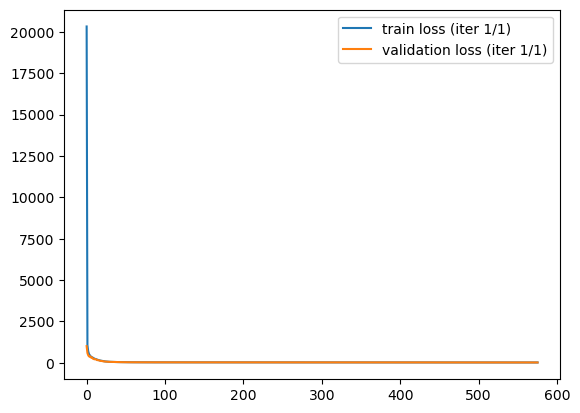

Surrogate vs Simulator y-space C2ST AUC after iteration 0: 0.64295
Surrogate vs Simulator y-space SWD AUC after iteration 0: 0.525463342666626
Epoch x Chunk: 0, Weighted Loss: 6.269183355996869, Entropy loss: 6.269183355996869, Wasser loss: 0.899308979511261
Epoch x Chunk: 500, Weighted Loss: -0.03417666423098792, Entropy loss: 1.402789841773889, Wasser loss: -0.8079278469085693
Epoch x Chunk: 1000, Weighted Loss: -0.15522039398648513, Entropy loss: 1.4420625255260964, Wasser loss: -1.0152958631515503
Epoch x Chunk: 1500, Weighted Loss: -0.14372145575692707, Entropy loss: 1.464497743228736, Wasser loss: -1.0096856355667114
Training loss did not improve. Stopped training after 1508 epochs x chunks.
y c2st AUC on simulator: 0.54435
y c2st AUC on surrogate: 0.5471999999999999
Source c2st AUC: 0.7614
Ground truth source entropy estimate: 9.165601713214292
Estimated source entropy estimate: 9.702668620135722
--__----__----__----__----__----__----__----__----__----__--


In [84]:
surro_train_domain_distribution = box_domain  # initialization
train_losses = []
val_losses = []
train_source_losses = []

iteration = 0
# start loop here, don't initialize surrogate again!
for _ in range(NUMBER_OF_ITERATIONS):
    print(f"ITERATION: {iteration+1}/{NUMBER_OF_ITERATIONS} training with {BUDGET_PER_ITERATION[_]} samples")
    surro_train_domain = surro_train_domain_distribution.sample(BUDGET_PER_ITERATION[_]).detach()#?
    surro_train_push_forward = simulator.sample(surro_train_domain) # real simulator, budget
    

    train_dataset, val_dataset = create_train_val_dataloaders(
        surro_train_push_forward, # observations: x
        surro_train_domain,       #   parameters: θ
    )

    train_loss, val_loss = fit_conditional_normalizing_flow(
        network=surrogate,
        optimizer=surro_optimizer,
        training_dataset=train_dataset,
        validation_dataset=val_dataset,
        nb_epochs=cfg.surrogate.nb_epochs,#//NUMBER_OF_ITERATIONS, ## shall we cut down on epochs?
        early_stopping_patience=cfg.surrogate.early_stopping_patience,
        print_every=500,
    )

    train_losses.extend(train_loss); val_losses.extend(val_loss) # concatenate losses across iterations
    
    if iteration == NUMBER_OF_ITERATIONS-1:
        # only save the final surrogate
        torch.save(
            surrogate.state_dict(),
            os.path.join(
                cfg.base.base_path, cfg.base.folder, f"{cfg.base.tag}_surrogate_{iteration}.pt"
            ),
        )
    
    plt.plot(train_loss, label=f"train loss (iter {iteration+1}/{NUMBER_OF_ITERATIONS})")
    plt.plot(val_loss, label=f"validation loss (iter {iteration+1}/{NUMBER_OF_ITERATIONS})")
    plt.legend()
    plt.show()
    
    # evaluate the current surrogate
    surrogate.eval()
    with torch.no_grad():
        # surrogate generated observations from the above 2 sets of 10k thetas
        gt_surrogate = surrogate.sample(size=cfg.source.num_obs, context=gt_source)
        gt_surrogate_two = surrogate.sample(size=cfg.source.num_eval_obs, context=gt_source_two)
    
    current_c2st = np.mean(c2st_scores(gt_simulator.cpu(), gt_surrogate.cpu()))
    current_swd = sliced_wasserstein_distance(gt_simulator, gt_surrogate,
                                              num_projections=4096, device=device
                                             ).item()
    
    print(f"Surrogate vs Simulator y-space C2ST AUC after iteration {iteration}: {current_c2st}")
    print(f"Surrogate vs Simulator y-space SWD AUC after iteration {iteration}: {current_swd}")
    
    
    # now fit a source with this new surrogate
    train_source_loss = train_source(
        data=gt_simulator, # observations sampled using simulator.sample(context=gt_source)
        source_model=source,
        simulator=surrogate,  ##### ALWAYS PASSING SURROGATE HERE!!!
        optimizer=optimizer,
        entro_dist=None,  # default uniform is used
        kld_samples=cfg.source.num_kole_samples, # 512
        entro_lambda=schedule,
        wasser_p=cfg.source.wasserstein_order,   # 2
        wasser_np=cfg.source.wasserstein_slices, # 500
        use_log_sw=cfg.source.use_log_sw,   # True => log_or_id = torch.log
        num_chunks=cfg.source.num_chunks,   # 1
        epochs=cfg.source.pretraining_steps # 0
        + cfg.source.linear_decay_steps     # 500
        + cfg.source.lambda_steps,          # 3000
        min_epochs_x_chus=cfg.source.pretraining_steps + cfg.source.linear_decay_steps,
        early_stopping_patience=cfg.source.early_stopping_patience, # 500
        device=device,
        print_every=500,
    )
    train_source_losses.extend(train_source_loss)
    
    # Evaluate trained source model
    source.eval()
    surrogate.eval()
    with torch.no_grad():
        # sample some θ-s from the estimated source
        estimated_source = source.sample(cfg.source.num_eval_obs)
        # sample some x-s from those θ-s from the surrogate (pushforward using surrogate)
        surro_estimated_pf = surrogate.sample(cfg.source.num_eval_obs, estimated_source)
        # sample some x-s from those θ-s from the actual simulator (pushforward using true simulator)
        simu_estimated_pf = simulator.sample(estimated_source)
    
    
    # Classifier two sample tests
    simu_c2st = np.mean(c2st_scores(simu_estimated_pf.cpu(), gt_simulator_two.cpu()))
    print(f"y c2st AUC on simulator: {simu_c2st}")
    
    surro_c2st = np.mean(c2st_scores(surro_estimated_pf.cpu(), gt_surrogate_two.cpu()))
    print(f"y c2st AUC on surrogate: {surro_c2st}")
    
    source_c2st = np.mean(
        c2st_scores( # 2 `sets` of samples of thetas, from the estimated and the ground truth sources
            estimated_source.cpu(),
            gt_source_two.cpu(),
        )
    )
    print(f"Source c2st AUC: {source_c2st}")

    # print("Estimate source entropies")
    gt_source_kole = kozachenko_leonenko_estimator(gt_source_two, on_torus=False).item()
    estimated_source_kole = kozachenko_leonenko_estimator(
        estimated_source, on_torus=False
    ).item()
    
    print(f"Ground truth source entropy estimate: {gt_source_kole}")
    print(f"Estimated source entropy estimate: {estimated_source_kole}")


    ## update the source for next iteration of updating the surrogate
    iteration += 1
    surro_train_domain_distribution = source
    print("--__--"*10)

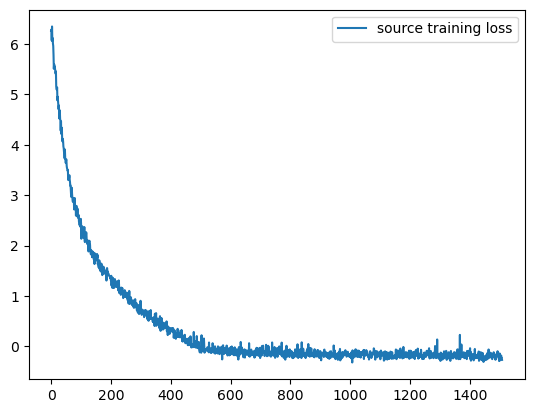

In [101]:
plt.plot(train_source_losses, label=f"source training loss")
plt.legend()
plt.show()

# 6000 one shot

ITERATION: 1/1 training with 6000 samples
Epoch: 0, Train Loss: 18259.064755088406, Val Loss: 1295.4876220703125
Epoch: 500, Train Loss: 26.80910953722502, Val Loss: 27.38017463684082
Validation loss did not improve for 50 epochs, stopping training after 943 epochs.


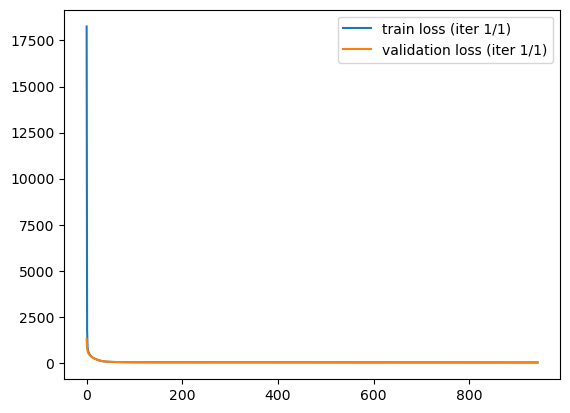

Surrogate vs Simulator y-space C2ST AUC after iteration 0: 0.6182500000000001
Surrogate vs Simulator y-space SWD AUC after iteration 0: 0.4226246178150177
Epoch x Chunk: 0, Weighted Loss: 6.269183355996869, Entropy loss: 6.269183355996869, Wasser loss: 0.9501497745513916
Epoch x Chunk: 500, Weighted Loss: -0.13467849543194876, Entropy loss: 1.4950336628448193, Wasser loss: -1.0122158527374268
Epoch x Chunk: 1000, Weighted Loss: -0.28752169668804173, Entropy loss: 1.4901419263213755, Wasser loss: -1.244725227355957
Epoch x Chunk: 1500, Weighted Loss: -0.21691969982372294, Entropy loss: 1.5242277713886354, Wasser loss: -1.1544606685638428
Training loss did not improve. Stopped training after 1699 epochs x chunks.
y c2st AUC on simulator: 0.5504
y c2st AUC on surrogate: 0.5489
Source c2st AUC: 0.76875
Ground truth source entropy estimate: 9.165601713214292
Estimated source entropy estimate: 9.713248609480807
--__----__----__----__----__----__----__----__----__----__--


In [64]:
surro_train_domain_distribution = box_domain  # initialization
train_losses = []
val_losses = []
train_source_losses = []

iteration = 0
# start loop here, don't initialize surrogate again!
for _ in range(NUMBER_OF_ITERATIONS):
    print(f"ITERATION: {iteration+1}/{NUMBER_OF_ITERATIONS} training with {BUDGET_PER_ITERATION[_]} samples")
    surro_train_domain = surro_train_domain_distribution.sample(BUDGET_PER_ITERATION[_]).detach()#?
    surro_train_push_forward = simulator.sample(surro_train_domain) # real simulator, budget
    

    train_dataset, val_dataset = create_train_val_dataloaders(
        surro_train_push_forward, # observations: x
        surro_train_domain,       #   parameters: θ
    )

    train_loss, val_loss = fit_conditional_normalizing_flow(
        network=surrogate,
        optimizer=surro_optimizer,
        training_dataset=train_dataset,
        validation_dataset=val_dataset,
        nb_epochs=cfg.surrogate.nb_epochs,#//NUMBER_OF_ITERATIONS, ## shall we cut down on epochs?
        early_stopping_patience=cfg.surrogate.early_stopping_patience,
        print_every=500,
    )

    train_losses.extend(train_loss); val_losses.extend(val_loss) # concatenate losses across iterations
    
    if iteration == NUMBER_OF_ITERATIONS-1:
        # only save the final surrogate
        torch.save(
            surrogate.state_dict(),
            os.path.join(
                cfg.base.base_path, cfg.base.folder, f"{cfg.base.tag}_surrogate_{iteration}.pt"
            ),
        )
    
    plt.plot(train_loss, label=f"train loss (iter {iteration+1}/{NUMBER_OF_ITERATIONS})")
    plt.plot(val_loss, label=f"validation loss (iter {iteration+1}/{NUMBER_OF_ITERATIONS})")
    plt.legend()
    plt.show()
    
    # evaluate the current surrogate
    surrogate.eval()
    with torch.no_grad():
        # surrogate generated observations from the above 2 sets of 10k thetas
        gt_surrogate = surrogate.sample(size=cfg.source.num_obs, context=gt_source)
        gt_surrogate_two = surrogate.sample(size=cfg.source.num_eval_obs, context=gt_source_two)
    
    current_c2st = np.mean(c2st_scores(gt_simulator.cpu(), gt_surrogate.cpu()))
    current_swd = sliced_wasserstein_distance(gt_simulator, gt_surrogate,
                                              num_projections=4096, device=device
                                             ).item()
    
    print(f"Surrogate vs Simulator y-space C2ST AUC after iteration {iteration}: {current_c2st}")
    print(f"Surrogate vs Simulator y-space SWD AUC after iteration {iteration}: {current_swd}")
    
    
    # now fit a source with this new surrogate
    train_source_loss = train_source(
        data=gt_simulator, # observations sampled using simulator.sample(context=gt_source)
        source_model=source,
        simulator=surrogate,  ##### ALWAYS PASSING SURROGATE HERE!!!
        optimizer=optimizer,
        entro_dist=None,  # default uniform is used
        kld_samples=cfg.source.num_kole_samples, # 512
        entro_lambda=schedule,
        wasser_p=cfg.source.wasserstein_order,   # 2
        wasser_np=cfg.source.wasserstein_slices, # 500
        use_log_sw=cfg.source.use_log_sw,   # True => log_or_id = torch.log
        num_chunks=cfg.source.num_chunks,   # 1
        epochs=cfg.source.pretraining_steps # 0
        + cfg.source.linear_decay_steps     # 500
        + cfg.source.lambda_steps,          # 3000
        min_epochs_x_chus=cfg.source.pretraining_steps + cfg.source.linear_decay_steps,
        early_stopping_patience=cfg.source.early_stopping_patience, # 500
        device=device,
        print_every=500,
    )
    train_source_losses.extend(train_source_loss)
    
    # Evaluate trained source model
    source.eval()
    surrogate.eval()
    with torch.no_grad():
        # sample some θ-s from the estimated source
        estimated_source = source.sample(cfg.source.num_eval_obs)
        # sample some x-s from those θ-s from the surrogate (pushforward using surrogate)
        surro_estimated_pf = surrogate.sample(cfg.source.num_eval_obs, estimated_source)
        # sample some x-s from those θ-s from the actual simulator (pushforward using true simulator)
        simu_estimated_pf = simulator.sample(estimated_source)
    
    
    # Classifier two sample tests
    simu_c2st = np.mean(c2st_scores(simu_estimated_pf.cpu(), gt_simulator_two.cpu()))
    print(f"y c2st AUC on simulator: {simu_c2st}")
    
    surro_c2st = np.mean(c2st_scores(surro_estimated_pf.cpu(), gt_surrogate_two.cpu()))
    print(f"y c2st AUC on surrogate: {surro_c2st}")
    
    source_c2st = np.mean(
        c2st_scores( # 2 `sets` of samples of thetas, from the estimated and the ground truth sources
            estimated_source.cpu(),
            gt_source_two.cpu(),
        )
    )
    print(f"Source c2st AUC: {source_c2st}")

    # print("Estimate source entropies")
    gt_source_kole = kozachenko_leonenko_estimator(gt_source_two, on_torus=False).item()
    estimated_source_kole = kozachenko_leonenko_estimator(
        estimated_source, on_torus=False
    ).item()
    
    print(f"Ground truth source entropy estimate: {gt_source_kole}")
    print(f"Estimated source entropy estimate: {estimated_source_kole}")


    ## update the source for next iteration of updating the surrogate
    iteration += 1
    surro_train_domain_distribution = source
    print("--__--"*10)

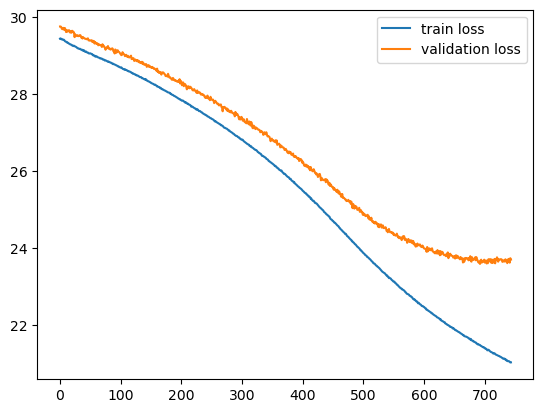

In [67]:
start_idx=200
plt.plot(train_losses[start_idx:], label=f"train loss")
plt.plot(val_losses[start_idx:], label=f"validation loss")
plt.legend()
plt.show()

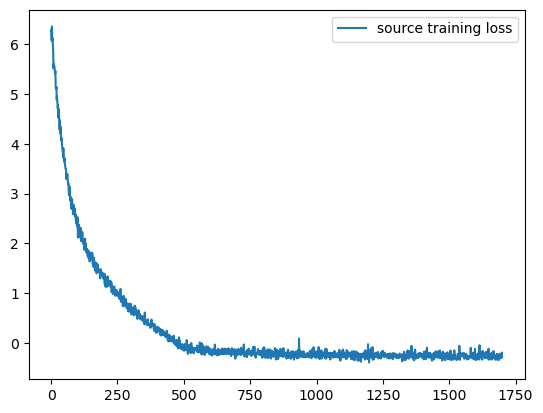

In [65]:
plt.plot(train_source_losses, label=f"source training loss")
plt.legend()
plt.show()

## 5000 one shot

ITERATION: 1/1 training with 5000 samples
Epoch: 0, Train Loss: 13544.552551269531, Val Loss: 2428.758056640625
Epoch: 500, Train Loss: 27.390628695487976, Val Loss: 28.029046058654785


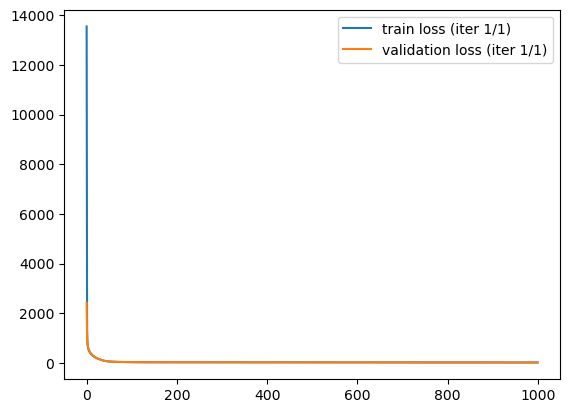

Surrogate vs Simulator y-space C2ST AUC after iteration 0: 0.63285
Surrogate vs Simulator y-space SWD AUC after iteration 0: 0.4107383191585541
Epoch x Chunk: 0, Weighted Loss: 6.269183355996869, Entropy loss: 6.269183355996869, Wasser loss: 0.9163742661476135
Epoch x Chunk: 500, Weighted Loss: -0.12548094763585615, Entropy loss: 1.5010048981613844, Wasser loss: -1.0012810230255127
Epoch x Chunk: 1000, Weighted Loss: -0.20696091192290433, Entropy loss: 1.589644506331326, Wasser loss: -1.1743638515472412
Epoch x Chunk: 1500, Weighted Loss: -0.20336010969217466, Entropy loss: 1.5231172810660807, Wasser loss: -1.1330018043518066
Epoch x Chunk: 2000, Weighted Loss: -0.24021012302638123, Entropy loss: 1.5680725297599318, Wasser loss: -1.2139008045196533
Epoch x Chunk: 2500, Weighted Loss: -0.230861725064619, Entropy loss: 1.5619646019007023, Wasser loss: -1.1962298154830933
Training loss did not improve. Stopped training after 2868 epochs x chunks.
y c2st AUC on simulator: 0.5447
y c2st AUC

In [42]:
surro_train_domain_distribution = box_domain  # initialization
train_losses = []
val_losses = []
train_source_losses = []

iteration = 0
# start loop here, don't initialize surrogate again!
for _ in range(NUMBER_OF_ITERATIONS):
    print(f"ITERATION: {iteration+1}/{NUMBER_OF_ITERATIONS} training with {BUDGET_PER_ITERATION[_]} samples")
    surro_train_domain = surro_train_domain_distribution.sample(BUDGET_PER_ITERATION[_]).detach()#?
    surro_train_push_forward = simulator.sample(surro_train_domain) # real simulator, budget
    

    train_dataset, val_dataset = create_train_val_dataloaders(
        surro_train_push_forward, # observations: x
        surro_train_domain,       #   parameters: θ
    )

    train_loss, val_loss = fit_conditional_normalizing_flow(
        network=surrogate,
        optimizer=surro_optimizer,
        training_dataset=train_dataset,
        validation_dataset=val_dataset,
        nb_epochs=cfg.surrogate.nb_epochs,#//NUMBER_OF_ITERATIONS, ## shall we cut down on epochs?
        early_stopping_patience=cfg.surrogate.early_stopping_patience,
        print_every=500,
    )

    train_losses.extend(train_loss); val_losses.extend(val_loss) # concatenate losses across iterations
    
    if iteration == NUMBER_OF_ITERATIONS-1:
        # only save the final surrogate
        torch.save(
            surrogate.state_dict(),
            os.path.join(
                cfg.base.base_path, cfg.base.folder, f"{cfg.base.tag}_surrogate_{iteration}.pt"
            ),
        )
    
    plt.plot(train_loss, label=f"train loss (iter {iteration+1}/{NUMBER_OF_ITERATIONS})")
    plt.plot(val_loss, label=f"validation loss (iter {iteration+1}/{NUMBER_OF_ITERATIONS})")
    plt.legend()
    plt.show()
    
    # evaluate the current surrogate
    surrogate.eval()
    with torch.no_grad():
        # surrogate generated observations from the above 2 sets of 10k thetas
        gt_surrogate = surrogate.sample(size=cfg.source.num_obs, context=gt_source)
        gt_surrogate_two = surrogate.sample(size=cfg.source.num_eval_obs, context=gt_source_two)
    
    current_c2st = np.mean(c2st_scores(gt_simulator.cpu(), gt_surrogate.cpu()))
    current_swd = sliced_wasserstein_distance(gt_simulator, gt_surrogate,
                                              num_projections=4096, device=device
                                             ).item()
    
    print(f"Surrogate vs Simulator y-space C2ST AUC after iteration {iteration}: {current_c2st}")
    print(f"Surrogate vs Simulator y-space SWD AUC after iteration {iteration}: {current_swd}")
    
    
    # now fit a source with this new surrogate
    train_source_loss = train_source(
        data=gt_simulator, # observations sampled using simulator.sample(context=gt_source)
        source_model=source,
        simulator=surrogate,  ##### ALWAYS PASSING SURROGATE HERE!!!
        optimizer=optimizer,
        entro_dist=None,  # default uniform is used
        kld_samples=cfg.source.num_kole_samples, # 512
        entro_lambda=schedule,
        wasser_p=cfg.source.wasserstein_order,   # 2
        wasser_np=cfg.source.wasserstein_slices, # 500
        use_log_sw=cfg.source.use_log_sw,   # True => log_or_id = torch.log
        num_chunks=cfg.source.num_chunks,   # 1
        epochs=cfg.source.pretraining_steps # 0
        + cfg.source.linear_decay_steps     # 500
        + cfg.source.lambda_steps,          # 3000
        min_epochs_x_chus=cfg.source.pretraining_steps + cfg.source.linear_decay_steps,
        early_stopping_patience=cfg.source.early_stopping_patience, # 500
        device=device,
        print_every=500,
    )
    train_source_losses.extend(train_source_loss)
    
    # Evaluate trained source model
    source.eval()
    surrogate.eval()
    with torch.no_grad():
        # sample some θ-s from the estimated source
        estimated_source = source.sample(cfg.source.num_eval_obs)
        # sample some x-s from those θ-s from the surrogate (pushforward using surrogate)
        surro_estimated_pf = surrogate.sample(cfg.source.num_eval_obs, estimated_source)
        # sample some x-s from those θ-s from the actual simulator (pushforward using true simulator)
        simu_estimated_pf = simulator.sample(estimated_source)
    
    
    # Classifier two sample tests
    simu_c2st = np.mean(c2st_scores(simu_estimated_pf.cpu(), gt_simulator_two.cpu()))
    print(f"y c2st AUC on simulator: {simu_c2st}")
    
    surro_c2st = np.mean(c2st_scores(surro_estimated_pf.cpu(), gt_surrogate_two.cpu()))
    print(f"y c2st AUC on surrogate: {surro_c2st}")
    
    source_c2st = np.mean(
        c2st_scores( # 2 `sets` of samples of thetas, from the estimated and the ground truth sources
            estimated_source.cpu(),
            gt_source_two.cpu(),
        )
    )
    print(f"Source c2st AUC: {source_c2st}")

    # print("Estimate source entropies")
    gt_source_kole = kozachenko_leonenko_estimator(gt_source_two, on_torus=False).item()
    estimated_source_kole = kozachenko_leonenko_estimator(
        estimated_source, on_torus=False
    ).item()
    
    print(f"Ground truth source entropy estimate: {gt_source_kole}")
    print(f"Estimated source entropy estimate: {estimated_source_kole}")


    ## update the source for next iteration of updating the surrogate
    iteration += 1
    surro_train_domain_distribution = source
    print("--__--"*10)

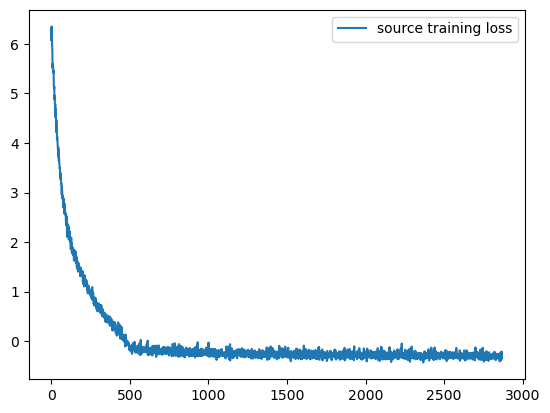

In [47]:
plt.plot(train_source_losses, label=f"source training loss")
plt.legend()
plt.show()

In [45]:
train_source_losses

-0.3491722807545886

ITERATION: 1/1 training with 2000 samples
Epoch: 0, Train Loss: 24310.85374232701, Val Loss: 18606.252685546875
Validation loss did not improve for 50 epochs, stopping training after 444 epochs.


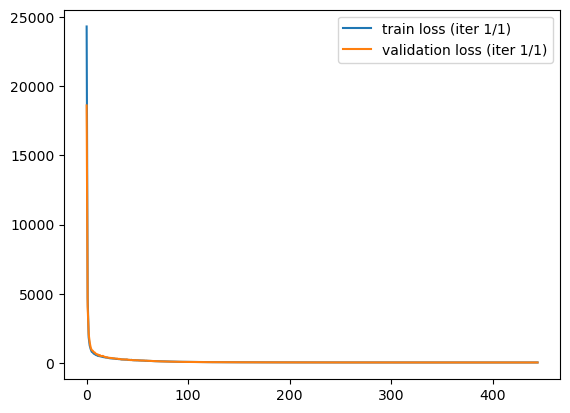

Surrogate vs Simulator y-space C2ST AUC Iteration: 0: 0.8083
Surrogate vs Simulator y-space SWD AUC Iteration: 0: 4.0704851150512695
Epoch x Chunk: 0, Weighted Loss: 6.269183355996869, Entropy loss: 6.269183355996869, Wasser loss: 0.6716846227645874
Epoch x Chunk: 500, Weighted Loss: 1.6357003413115667, Entropy loss: 0.8765569850100041, Wasser loss: 1.9610475301742554
Epoch x Chunk: 1000, Weighted Loss: 1.5232157038703773, Entropy loss: 1.269697472350967, Wasser loss: 1.631866455078125
Epoch x Chunk: 1500, Weighted Loss: 1.6391083408194562, Entropy loss: 1.5729587012008617, Wasser loss: 1.667458176612854
Epoch x Chunk: 2000, Weighted Loss: 1.545324626648919, Entropy loss: 1.501662085667422, Wasser loss: 1.5640372037887573
Training loss did not improve. Stopped training after 2207 epochs x chunks.
y c2st AUC on simulator: 0.5874499999999999
y c2st AUC on surrogate: 0.5147999999999999
Source c2st AUC: 0.7426
--__----__----__----__----__----__----__----__----__----__--


In [15]:
surro_train_domain_distribution = box_domain  # initialization
train_losses = []
val_losses = []
iteration = 0

# start loop here, don't initialize surrogate again!
for _ in range(NUMBER_OF_ITERATIONS):
    print(f"ITERATION: {iteration+1}/{NUMBER_OF_ITERATIONS} training with {MINIMUM_SAMPLES_PER_ITERATION} samples")
    surro_train_domain = surro_train_domain_distribution.sample(MINIMUM_SAMPLES_PER_ITERATION).detach()#?
    surro_train_push_forward = simulator.sample(surro_train_domain) # real simulator, budget
    

    train_dataset, val_dataset = create_train_val_dataloaders(
        surro_train_push_forward, # observations: x
        surro_train_domain,       #   parameters: θ
    )

    train_loss, val_loss = fit_conditional_normalizing_flow(
        network=surrogate,
        optimizer=surro_optimizer,
        training_dataset=train_dataset,
        validation_dataset=val_dataset,
        nb_epochs=cfg.surrogate.nb_epochs,#//NUMBER_OF_ITERATIONS, ## shall we cut down on epochs?
        early_stopping_patience=cfg.surrogate.early_stopping_patience,
        print_every=500,
    )
    train_losses.append(train_loss); val_losses.append(val_loss) # concatenate losses across iterations
    
    if iteration == NUMBER_OF_ITERATIONS-1:
        # only save the final surrogate
        torch.save(
            surrogate.state_dict(),
            os.path.join(
                cfg.base.base_path, cfg.base.folder, f"{cfg.base.tag}_surrogate_{iteration}.pt"
            ),
        )
    
    plt.plot(train_loss, label=f"train loss (iter {iteration+1}/{NUMBER_OF_ITERATIONS})")
    plt.plot(val_loss, label=f"validation loss (iter {iteration+1}/{NUMBER_OF_ITERATIONS})")
    plt.legend()
    plt.show()
    
    # evaluate the current surrogate
    surrogate.eval()
    with torch.no_grad():
        # surrogate generated observations from the above 2 sets of 10k thetas
        gt_surrogate = surrogate.sample(size=cfg.source.num_obs, context=gt_source)
        gt_surrogate_two = surrogate.sample(size=cfg.source.num_eval_obs, context=gt_source_two)
    
    current_c2st = np.mean(c2st_scores(gt_simulator.cpu(), gt_surrogate.cpu()))
    current_swd = sliced_wasserstein_distance(gt_simulator, gt_surrogate,
                                              num_projections=4096, device=device
                                             ).item()
    
    print(f"Surrogate vs Simulator y-space C2ST AUC Iteration: {iteration}: {current_c2st}")
    print(f"Surrogate vs Simulator y-space SWD AUC Iteration: {iteration}: {current_swd}")
    
    
    # now fit a source with this new surrogate
    train_source(
        data=gt_simulator, # observations sampled using simulator.sample(context=gt_source)
        source_model=source,
        simulator=surrogate,  ##### ALWAYS PASSING SURROGATE HERE!!!
        optimizer=optimizer,
        entro_dist=None,  # default uniform is used
        kld_samples=cfg.source.num_kole_samples, # 512
        entro_lambda=schedule,
        wasser_p=cfg.source.wasserstein_order,   # 2
        wasser_np=cfg.source.wasserstein_slices, # 500
        use_log_sw=cfg.source.use_log_sw,   # True => log_or_id = torch.log
        num_chunks=cfg.source.num_chunks,   # 1
        epochs=cfg.source.pretraining_steps # 0
        + cfg.source.linear_decay_steps     # 500
        + cfg.source.lambda_steps,          # 3000
        min_epochs_x_chus=cfg.source.pretraining_steps + cfg.source.linear_decay_steps,
        early_stopping_patience=cfg.source.early_stopping_patience, # 500
        device=device,
        print_every=500,
    )
    
    # Evaluate trained source model
    source.eval()
    surrogate.eval()
    with torch.no_grad():
        # sample some θ-s from the estimated source
        estimated_source = source.sample(cfg.source.num_eval_obs)
        # sample some x-s from those θ-s from the surrogate (pushforward using surrogate)
        surro_estimated_pf = surrogate.sample(cfg.source.num_eval_obs, estimated_source)
        # sample some x-s from those θ-s from the actual simulator (pushforward using true simulator)
        simu_estimated_pf = simulator.sample(estimated_source)
    
    
    # Classifier two sample tests
    simu_c2st = np.mean(c2st_scores(simu_estimated_pf.cpu(), gt_simulator_two.cpu(), ))
    print(f"y c2st AUC on simulator: {simu_c2st}")
    
    surro_c2st = np.mean(
        c2st_scores(
            surro_estimated_pf.cpu(),
            gt_surrogate_two.cpu(),
        )
    )
    print(f"y c2st AUC on surrogate: {surro_c2st}")
    
    source_c2st = np.mean(
        c2st_scores( # samples of thetas
            estimated_source.cpu(),
            gt_source_two.cpu(),
        )
    )
    print(f"Source c2st AUC: {source_c2st}")
    
    
    ## update the source for next iteration of updating the surrogate
    iteration += 1
    surro_train_domain_distribution = source
    print("--__--"*10)

In [51]:
torch.cuda.empty_cache()
!nvidia-smi

Sat Nov 16 15:34:14 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080 Ti     On  | 00000000:DB:00.0 Off |                  N/A |
|  0%   32C    P8              29W / 250W |    519MiB / 11264MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [19]:
cfg.source.fin_lambda

0.3